In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from astropy import constants as const
from scipy import interpolate
from bit_tools.mission_tools import Mission
mpl.rc('font', family='serif', serif = "cmr10", size=18)
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams["errorbar.capsize"] = 5
mpl.rcParams['axes.unicode_minus'] = False

from mag_converter import *

/home/veome/anaconda3/lib/python3.8/site-packages/pyds9.py:94: UserWarning: Can't locate DS9 executable. Please add the DS9 directory to your PATH and try again.
  warnings.warn(ds9_warning)


In [2]:
# # Get HST F814W Band from http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=HST/WFC3_UVIS2.F814W
# f814w_band_response = np.genfromtxt('HST_WFC3_UVIS2.F814W.dat', usecols=range(2), delimiter=' ', invalid_raise=False)
# f814w = interpolate.interp1d(f814w_band_response[:,0], f814w_band_response[:,1], fill_value="extrapolate")

# Get HST F814W Band from bit_tools/bit_tools/data/missions/superbit/bandpass/
hst = Mission("hst")
band = hst.get_bandpass("f814w")
f814w_band_response = band.r_lam
f814w_pivot = band.lam_pivot * (u.nm.to(u.AA))
# Change units from nm to Angstrom
x = band.get_wavelengths() 
f814w = interpolate.interp1d(x*10, f814w_band_response(x), fill_value="extrapolate")

In [3]:
# Get SuperBIT Shape Band from bit_tools/bit_tools/data/missions/superbit/bandpass/
bit = Mission("superbit")
r_shape = bit.get_bandpass("shape").r_lam
shape_pivot = bit.get_bandpass("shape").lam_pivot * (u.nm.to(u.AA))
# r_shape = bit.get_bandpass("u").r_lam

# Change units from nm to Angstrom
# x = bit.get_bandpass("shape").get_wavelengths() #gives weird behavior outside wavelength range
x = np.arange(300, 1200, 1)
sbit_shape = interpolate.interp1d(x*10, r_shape(x), fill_value="extrapolate")

In [4]:
# Get SuperBIT19 Lum Band from bit_tools/bit_tools/data/missions/superbit19/bandpass/
bit19 = Mission("superbit19")
r_lum = bit19.get_bandpass("lum").r_lam
lum_pivot = bit19.get_bandpass("lum").lam_pivot * (u.nm.to(u.AA))
# r_shape = bit.get_bandpass("u").r_lam

# Change units from nm to Angstrom
# x = bit.get_bandpass("shape").get_wavelengths() #gives weird behavior outside wavelength range
x = np.arange(300, 1200, 1)
sbit_lum = interpolate.interp1d(x*10, r_lum(x), fill_value="extrapolate")

In [5]:
elliptical_template = np.genfromtxt('galaxy_spectra_kinney96/elliptical_template.ascii', usecols=range(2), invalid_raise=False)

starburst_all = [[], [], [], [], [], []]
for i in range(1, 7):
    starburst_all[i-1] = np.genfromtxt('galaxy_spectra_kinney96/starb%i_template.ascii' %(i), usecols=range(2), invalid_raise=False)

starburst_template = np.mean( np.array([starburst_all[0], starburst_all[1], starburst_all[2], starburst_all[3], starburst_all[4], starburst_all[5]]), axis=0 )

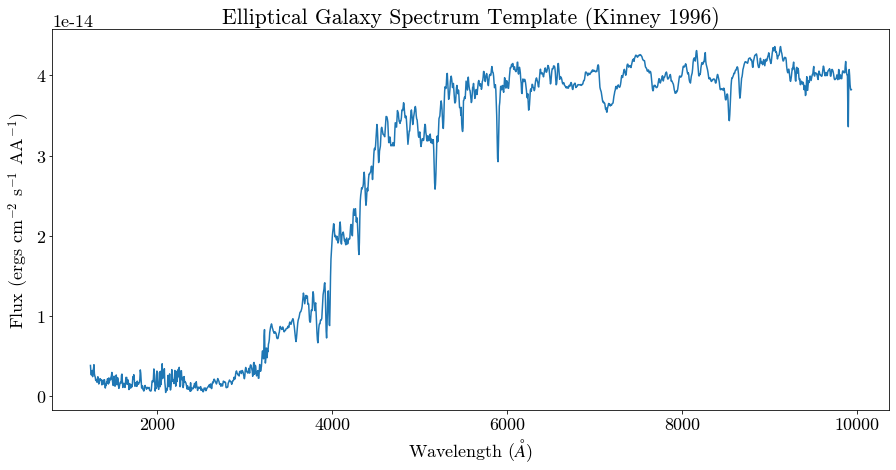

In [6]:
plt.figure(figsize=(15,7))

plt.plot(elliptical_template[:,0], elliptical_template[:,1], label='Elliptical Spectrum')

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux (ergs cm$^{-2}$ s$^{-1}$ AA$^{-1}$)')
plt.title('Elliptical Galaxy Spectrum Template (Kinney 1996)')

# plt.ylim(0, 6.6e-14)
plt.show()

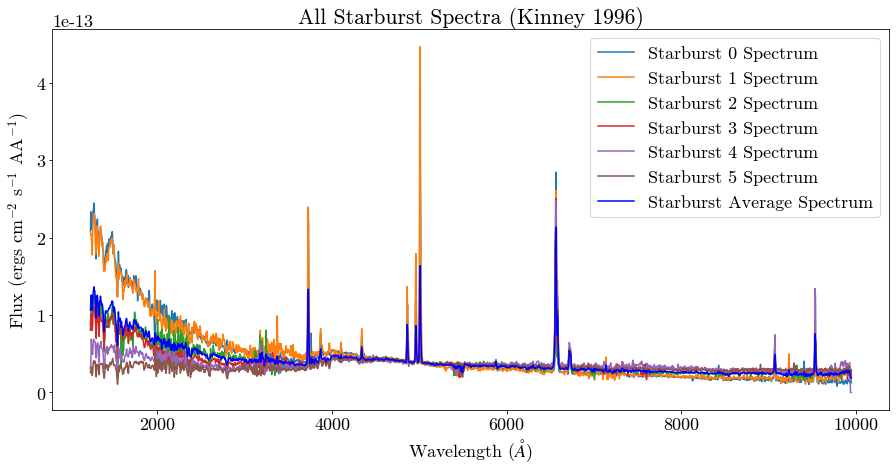

In [7]:
plt.figure(figsize=(15,7))

for i in range(6):
    plt.plot(starburst_all[i][:,0], starburst_all[i][:,1], label='Starburst %i Spectrum' %(i))

plt.plot(starburst_template[:,0], starburst_template[:,1], label='Starburst Average Spectrum', color='b')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux (ergs cm$^{-2}$ s$^{-1}$ AA$^{-1}$)')
plt.legend()
plt.title('All Starburst Spectra (Kinney 1996)')

plt.show()

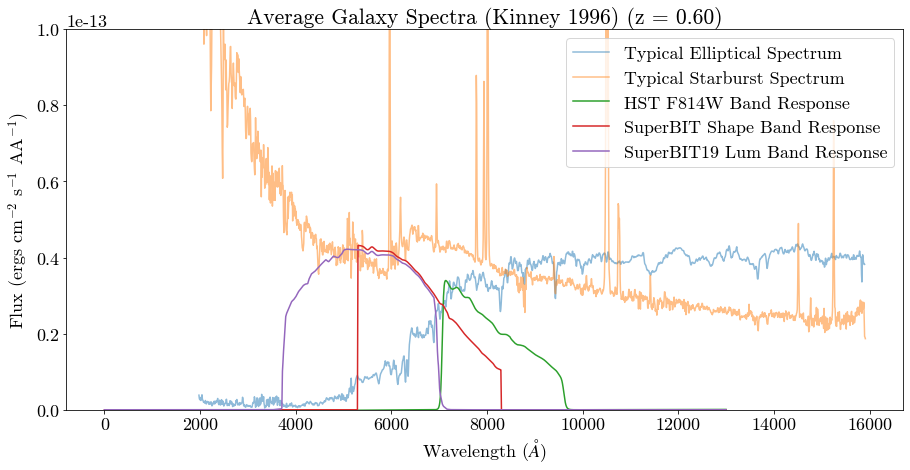

In [8]:
REDSHIFT = 0.6

plt.figure(figsize=(15,7))

ls = np.arange(0, 13000, 1)
a1 = 0.5
a2 = 1.0

plt.plot(elliptical_template[:,0]* (1+REDSHIFT), elliptical_template[:,1], label='Typical Elliptical Spectrum', alpha=a1)
plt.plot(starburst_template[:,0]* (1+REDSHIFT), starburst_template[:,1], label='Typical Starburst Spectrum', alpha=a1)
plt.plot(ls, f814w(ls)*1.5e-13, label='HST F814W Band Response', alpha=a2)
plt.plot(ls, sbit_shape(ls)*1.5e-13, label='SuperBIT Shape Band Response', alpha=a2)
plt.plot(ls, sbit_lum(ls)*1.5e-13, label='SuperBIT19 Lum Band Response', alpha=a2)


plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux (ergs cm$^{-2}$ s$^{-1}$ AA$^{-1}$)')
plt.title('Average Galaxy Spectra (Kinney 1996) (z = %.2f)' %(REDSHIFT))

plt.legend()
# plt.legend(bbox_to_anchor=(0.6, 0.6))
plt.ylim(0, 1.0e-13)

# plt.savefig("spectra_overview.png")
plt.show()


https://www.astro.ljmu.ac.uk/~ikb/research/mags-fluxes/ $$ $$
https://mfouesneau.github.io/docs/pyphot/photometry.html $$ $$

For a given filter response function $R(\lambda)$ $[unitless]$ and source galaxy spectral flux density $f_\lambda (\lambda)$ $[ergs/cm^2/s/Angstrom]$, the expected spectral flux density is:
$$\langle f_\lambda \rangle = \frac{\int d\lambda \; \lambda \; R \; f_\lambda}{\int d\lambda \; \lambda \; R}$$

Then, the observed ST magnitude is
$$ m_{\text{ST}} = -2.5 \log_{10} ( \langle f_\lambda \rangle) - 21.1$$


and the observed AB magnitude is
$$ m_{\text{AB}} = -2.5 \log_{10} ( \langle f_\lambda \rangle) - -2.5 \log_{10}(\lambda_p^2/c) - 48.6$$
where $\lambda_p$ is the pivot wavelength of the filter.



## ST Mag Conversion

Given a source ST Magnitude, we can recover
$$\langle f_\lambda \rangle =  10^{-(m+21.1)/2.5}$$

Then, for a given filter, we can use the relation
$$\langle f_\lambda \rangle = \frac{\int d\lambda \; \lambda \; R \; f_\lambda}{\int d\lambda \; \lambda \; R }$$

Thus, if we need to correct the flux density by a factor $\gamma$, we can simply scale the spectrum $f_\lambda$ by $\gamma$, such that
$$\gamma \; \langle f_\lambda \rangle = \frac{\int d\lambda \; \lambda \; R \; \gamma \; f_\lambda}{\int d\lambda \; \lambda \; R}$$

The correction to the spectral flux density is given by:
$$ \gamma = 10^{\frac{m_{\text{exp}}}{2.5} - \frac{m_{\text{obs}}}{2.5}}.$$

In [9]:
# Test calculation with units
e_wavelength = elliptical_template[:,0]  * u.AA # Angstrom
e_flux = elliptical_template[:,1] * u.erg / (u.AA * u.s * u.cm**2) # erg s^-1 cm^-2 Angstrom^-1
r = f814w(e_wavelength) # unitless

non0_indices = np.nonzero(e_flux)

r = r[non0_indices]
lam = e_wavelength[non0_indices]
f_lam = e_flux[non0_indices]
 
f1 = np.trapz(y=f_lam * r * lam, x=lam)
f2 = np.trapz(y=r * lam, x=lam) 

f_exp = f1/f2 # erg s^-1 cm^-2 AA^-1
print("f_lambda = %s" %f_exp)

mag = -2.5 * np.log10(f_exp.value) - 21.1
print("ST Magnitude = %.2f" %mag)

f_lambda = 4.0273498449172776e-14 erg / (Angstrom cm2 s)
ST Magnitude = 12.39


In [13]:
# Test the mag conversion
mag_obs = 23.2
z = 0.55

super_e_mag, super_starb_mag = stmag_conversion(mag_obs, z, f814w, sbit_shape, elliptical_template, starburst_template)
# hst_e_mag, hst_starb_mag

print("Original HST ST Mag: %.2f" %mag_obs)
# print("")
# print("HST Refitted Elliptical ST Mag: %.2f" %hst_e_mag)
# print("HST Refitted Starburst ST Mag: %.2f" %hst_starb_mag)
# print("")
print("SuperBIT Elliptical ST Mag: %.2f" %super_e_mag)
print("SuperBIT Starburst ST Mag: %.2f" %super_starb_mag)

Original HST ST Mag: 23.20
SuperBIT Elliptical ST Mag: 23.75
SuperBIT Starburst ST Mag: 23.09


## AB Mag Conversion

https://www.astro.ljmu.ac.uk/~ikb/research/mags-fluxes/ $$ $$
https://mfouesneau.github.io/docs/pyphot/photometry.html $$ $$

For a given filter response function $R(\lambda)$ $[unitless]$ and source galaxy spectral flux density $f_\lambda (\lambda)$ $[ergs/cm^2/s/Angstrom]$, the expected spectral flux density is:
$$\langle f_\lambda \rangle = \frac{\int d\lambda \; \lambda \; R \; f_\lambda}{\int d\lambda \; \lambda \; R}$$

Then, the observed AB magnitude is
$$ m_{\text{AB}} = -2.5 \log_{10} ( \langle f_\lambda \rangle) - -2.5 \log_{10}(\lambda_p^2/c) - 48.6$$
where $\lambda_p$ is the pivot wavelength of the filter.



Given a source AB Magnitude, we can obtain the expected spectral flux density must have been
$$\langle f_\lambda \rangle = \frac{c}{\lambda^2_{p, obs}} 10^{-(m_{obs}+48.6)/2.5}$$

Then, for a given target filter, we can use the relation
$$\langle f_\lambda \rangle = \frac{\int d\lambda \; \lambda \; R \; f_\lambda}{\int d\lambda \; \lambda \; R }$$

Thus, if we need to correct the expected flux density by a factor $\gamma$, we can simply scale the entire spectrum $f_\lambda$ by $\gamma$, such that
$$\frac{\int d\lambda \; \lambda \; R \; \gamma \; f_\lambda}{\int d\lambda \; \lambda \; R} = \gamma \; \langle f_\lambda \rangle $$

The correction to the spectral flux density is given by:
$$ \gamma = 10^{\frac{m_{\text{exp}}}{2.5} - \frac{m_{\text{obs}}}{2.5}}.$$

In [11]:
# Test calculation with units
e_wavelength = elliptical_template[:,0]  * u.AA # Angstrom
e_flux = elliptical_template[:,1] * u.erg / (u.AA * u.s * u.cm**2) # erg s^-1 cm^-2 Angstrom^-1
r = f814w(e_wavelength) # unitless

non0_indices = np.nonzero(e_flux)

r = r[non0_indices]
lam = e_wavelength[non0_indices]
f_lam = e_flux[non0_indices]
 
f1 = np.trapz(y=f_lam * r * lam, x=lam)
f2 = np.trapz(y=r * lam, x=lam) 

f_exp = f1/f2 # erg s^-1 cm^-2 AA^-1
print("f_lambda = %s" %f_exp)

mag = -2.5 * np.log10(f_exp.value) - 2.5 * np.log10(f814w_pivot**2 / (const.c*u.s/u.m)) - 48.6
print("AB Magnitude = %.2f" %mag)

f_lambda = 4.0273498449172776e-14 erg / (Angstrom cm2 s)
AB Magnitude = -13.45


In [14]:
# Test the mag conversion
mag_obs = 23.2
z = 0.55

super_e_mag, super_starb_mag = abmag_conversion(mag_obs, z, f814w, sbit_shape, elliptical_template, starburst_template, src_pivot = f814w_pivot, target_pivot=shape_pivot)
# hst_e_mag, hst_starb_mag

print("Original HST AB Mag: %.2f" %mag_obs)
# print("")
# print("HST Refitted Elliptical Mag: %.2f" %hst_e_mag)
# print("HST Refitted Starburst Mag: %.2f" %hst_starb_mag)
# print("")
print("SuperBIT Elliptical AB Mag: %.2f" %super_e_mag)
print("SuperBIT Starburst AB Mag: %.2f" %super_starb_mag)

Original HST AB Mag: 23.20
SuperBIT Elliptical AB Mag: 24.24
SuperBIT Starburst AB Mag: 23.57
